In [20]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


(256, 256, 4)


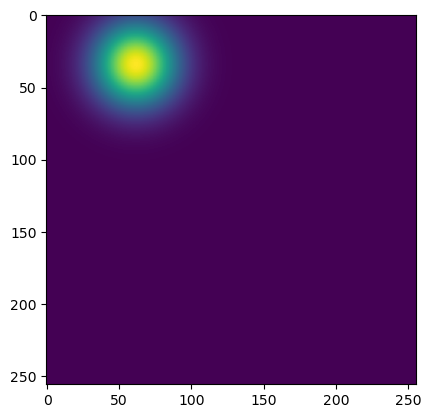

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from data_loading import OxfordPetDataset
from augmentation import batch
from models import clip_segmentation_model # 2_c exercise
from experiment import plot_results

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (256, 256)
dataset.res_norm(reshape_size)
dataset.mask_prep()
dataset.heatmaps()

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

print("\n")

for i, example in enumerate(train.take(1)):  # Take two examples
    mask = example['segmentation_mask']
    image_heatmap = example['image+heatmap']
    print(image_heatmap.shape)
    image = image_heatmap[:, :, :3]
    heatmap = image_heatmap[:, :, 3]
    
    plt.imshow(heatmap)


plt.show()

2025-03-13 17:26:26.483006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 17:26:26.484474: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 17:26:26.488623: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 17:26:26.502388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741886786.526154   11299 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741886786.53

Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


2025-03-13 17:26:33.993884: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-13 17:26:34.043297: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Unique values in region_interest_mask: [0 1]
Class of the location in the region_interest_mask: tf.Tensor(1, shape=(), dtype=int32)


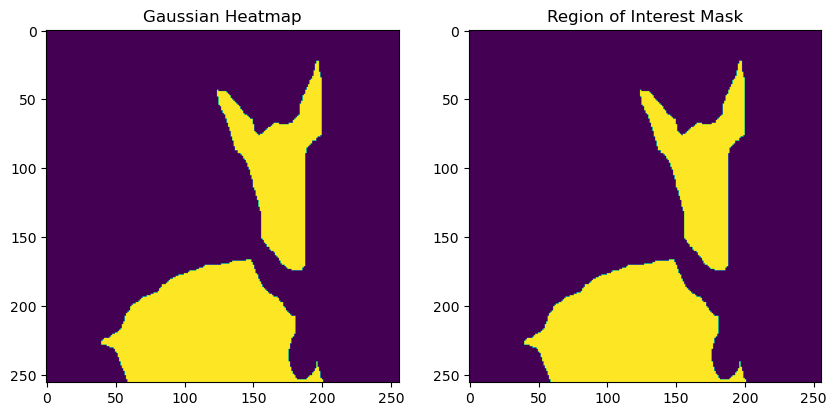

In [ ]:
import matplotlib.pyplot as plt
from point_segmentation import mask_heat_modification, random_loc, create_gaussian_heatmap

# First figure
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.title("Gaussian Heatmap")

import tensorflow as tf
import numpy as np
from data_loading import OxfordPetDataset
from augmentation import batch
from models import clip_segmentation_model  # 2_c exercise

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (256, 256)
dataset.res_norm(reshape_size)
dataset.mask_prep()
dataset.heatmaps()

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

for i, example in enumerate(train.take(1)):  # Take a single example
    mask = example['segmentation_mask']
    location = example['location']
    image_heatmap = example['image+heatmap']
    heatmap = image_heatmap[:, :, 3]
    original_mask = example['original_mask']
    unique_values = tf.unique(tf.reshape(tf.cast(original_mask, tf.int32), [-1]))[0]
    print("Unique values in region_interest_mask:", unique_values.numpy())
    location_class_uniquevalues = original_mask[location[0], location[1], 0]
    print("Class of the location in the region_interest_mask:", location_class_uniquevalues)

    plt.imshow(original_mask)

    plt.subplot(1, 2, 2)  # Second plot in the same figure
    plt.imshow(mask)
    plt.title("Region of Interest Mask")
    # Print unique values in the region_interest_mask
    unique_values = tf.unique(tf.reshape(tf.cast(mask, tf.int32), [-1]))[0]
    print("Unique values in region_interest_mask:", unique_values.numpy())
    location_class_uniquevalues = mask[location[0], location[1], 0]
    print("Class of the location in the region_interest_mask:", location_class_uniquevalues)

plt.show()


In [7]:
def extract_image_mask(data):
    """Extract image and mask from dictionary"""
    return data['image'], data['segmentation_mask']

In [31]:
from metrics import MeanIoUWrapper, dice_coefficient
import tensorflow as tf
from data_loading import OxfordPetDataset
import matplotlib.pyplot as plt
import os
import pandas as pd
from augmentation import batch

# Load the model
top_dir = "task_2c/baseline"
best_model_folder = os.path.join(top_dir, "Clip_model")
best_model = tf.keras.models.load_model(best_model_folder, compile=False)
best_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', MeanIoUWrapper(num_classes=3), dice_coefficient]
)

# Define results folder
results_folder = "test_results/Image_Salt_and_Pepper_Noise"
os.makedirs(results_folder, exist_ok=True)
test_csv_path = os.path.join(results_folder, "test_metrics.csv")

BATCH_SIZE = 32
# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
reshape_size = (256, 256)
dataset.res_norm(reshape_size)
dataset.mask_prep()

# List of perturbation levels
# num_times = [1, 2, 3, 4, 5, 6, 7, 8, 9] -> Gaussian Blurring
# std = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18] 
# brightness_up = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
# brightness_down = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
# contrast_up = [1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.1, 1.15, 1.20, 1.25]
# contrast_down = [1.0, 0.95, 0.90, 0.85, 0.80, 0.60, 0.40, 0.30, 0.20, 0.10]
# occlusion_up = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
gaussian_noise_impact = [0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18]
# Check if the CSV file exists to add headers only once
file_exists = os.path.isfile(test_csv_path)

for i in gaussian_noise_impact:
    # Apply perturbation (Gaussian pixel noise in this case)
    # dataset.first_perturb(std=i) 
    # Apply perturbation (Gaussian blurring in this case)
    # dataset.second_perturb(n=i)
    # Apply perturbation (mage contrast increase/decrease in this case)
    # dataset.third_perturb(a=i) 
    # Apply perturbation (Image brightness  in this case)
    # dataset.fourth_perturb(b=-i) 
    # Apply perturbation (Occlusion of Image increase  in this case)
    # dataset.fifth_perturb(p=i)
    # Apply perturbation (Salt and pepper noise  in this case)
    dataset.sixth_perturb(d=i) 

    # Prepare test dataset
    test = dataset.test_perturbed.map(extract_image_mask)
    test_ds = batch(test, augment='none', batch_size=BATCH_SIZE)

    # Evaluate the model on the perturbed dataset
    test_metrics = best_model.evaluate(test_ds, return_dict=True)
    print(f"Iteration {i}: {test_metrics}")
    iou_key = [key for key in test_metrics.keys() if key.startswith("mean_io_u_wrapper")][0]
    # Extract metrics
    test_results = {
        "Perturbation Level": [i],
        "Loss": [test_metrics['loss']],
        "Accuracy": [test_metrics['accuracy']],
        "IoU": [test_metrics[iou_key]],
        "Dice Coefficient": [test_metrics['dice_coefficient']]
    }

    # Convert to DataFrame
    test_results_df = pd.DataFrame(test_results)

    # Append results to CSV file
    test_results_df.to_csv(test_csv_path, mode='a', index=False, header=not file_exists)

    # After the first write, set file_exists to True so headers aren't repeated
    file_exists = True

    print(f"Test metrics for iteration {i} appended to {test_csv_path}")


C:\Users\vidia\anaconda3\envs\py310\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669
115/115 [==============================] - 54s 431ms/step - loss: 0.1709 - accuracy: 0.9294 - mean_io_u_wrapper_14: 0.8296 - dice_coefficient: 0.9044
Iteration 0.0: {'loss': 0.17088498175144196, 'accuracy': 0.9293954968452454, 'mean_io_u_wrapper_14': 0.8296310305595398, 'dice_coefficient': 0.9043943285942078}
Test metrics for iteration 0.0 appended to test_results/Image_Salt_and_Pepper_Noise\test_metrics.csv
115/115 [==============================] - 51s 433ms/step - loss: 0.2080 - accuracy: 0.9180 - mean_io_u_wrapper_14: 0.7959 - dice_coefficient: 0.8835
Iteration 0.02: {'loss': 0.20800556242465973, 'accuracy': 0.9179819226264954, 'mean_io_u_wrapper_14': 0.7958829402923584, 'dice_coefficient': 0.8835465908050537}
Test metrics for iteration 0.02 appended to test_results/Image_Salt_and_Pepper_Noise\test_metrics.csv
115/115 [==============================] - 52s 446ms/ste

In [16]:
import tensorflow as tf

x = tf.constant([[0, 2, 2], [2, 0, 0], [0, 2, 2]])
y = tf.constant([[1, 0, 2], [2, 1, 10], [5, 0, 1]])

mask = tf.constant([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
mask_bool = tf.cast(mask, tf.bool)

final = tf.where(mask_bool, x, y)

print(final)


tf.Tensor(
[[ 0  0  2]
 [ 2  0 10]
 [ 5  0  2]], shape=(3, 3), dtype=int32)
